# Auto Encoder + GAN
- Dataset: TinyImageNet <http://cs231n.stanford.edu/tiny-imagenet-200.zip>
- 200 class. 500 image per class.
- Input 32 x 32 | Output 64 x 64


## Dependencies

In [1]:
#!pip install torchvision matplotlib scikit-image

In [1]:
import os
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from PIL import Image

## Data Pre-Processing

### Transformations

In [2]:
transform_to_high_res = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

transform_to_low_res = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])

In [3]:
def load_tiny_imagenet_dataset(root_dir):
    lr_images = []
    hr_images = []

    for root, _, files in os.walk(root_dir):
        for file in files:
            if file.endswith(".JPEG"):
                img_path = os.path.join(root, file)
                image = Image.open(img_path).convert("RGB")
                high_resolution = transform_to_high_res(image)
                low_resolution = transform_to_low_res(image)
                hr_images.append(high_resolution)
                lr_images.append(low_resolution)

    # Stack into tensors
    lr_tensor = torch.stack(lr_images)
    hr_tensor = torch.stack(hr_images)
    return TensorDataset(lr_tensor, hr_tensor)

In [3]:
# Loading the data into the two resolutions and using a DataLoader
dataset_path = "dataset/tiny-imagenet-200/train"

#dataset = load_tiny_imagenet_dataset(dataset_path)

In [14]:
# To not waste time I am saving the tensors to be able to load on the go again
def save_preprocessed_tensors(dataset, save_dir="processed_data"):
    os.makedirs(save_dir, exist_ok=True)

    low_res_tensors, high_res_tensors = dataset.tensors
    
    torch.save(low_res_tensors, os.path.join(save_dir, "low_resolution.pt"))
    torch.save(high_res_tensors, os.path.join(save_dir, "high_resolution.pt"))
    print(f"Saved low-res: {low_res_tensors.shape} and high-res: {high_res_tensors.shape} to '{save_dir}'")

In [15]:
save_preprocessed_tensors(dataset)

Saved low-res: torch.Size([100000, 3, 32, 32]) and high-res: torch.Size([100000, 3, 64, 64]) to 'processed_data'


### Dataset Loader
- Load the saved tensor

In [4]:
def load_preprocessed_tensors(data_dir="processed_data", batch_size=64, shuffle=True, num_workers=2):
    lr_path = os.path.join(data_dir, "low_resolution.pt")
    hr_path = os.path.join(data_dir, "high_resolution.pt")

    lr_tensor = torch.load(lr_path)
    hr_tensor = torch.load(hr_path)

    dataset = TensorDataset(lr_tensor, hr_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

    print(f"Loaded : {len(dataset)} samples from '{data_dir}'")
    return dataloader

In [5]:
dataloader = load_preprocessed_tensors()

C:\Users\dravi\AppData\Local\Temp\ipykernel_21768\4095336838.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lr_tensor = torch.load(lr_path)
C:\Users\dravi\AppData\Local

Loaded : 100000 samples from 'processed_data'


## Generator

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),  # 32 -> 16
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), # 16 -> 8
            nn.ReLU(True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1), # 8 -> 4
            nn.ReLU(True)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1), # 4 -> 8
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 8 -> 16
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),    # 16 -> 32
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False), # 32 -> 64
            nn.Sigmoid()  # Since it's binary
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

## Discriminator

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            # 64x64 → 32x32
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            
            # 32x32 → 16x16
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            # 16x16 → 8x8
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            # 8x8 → 4x4
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Final: Flatten and classify
            nn.Flatten(),  # 512 * 4 * 4 = 8192
            nn.Linear(512 * 4 * 4, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x)

## Training

In [9]:
import torch.optim as optim
import matplotlib.pyplot as plt

def train(generator, discriminator, dataloader, num_epochs = 10, device = "cuda"):
    generator.to(device)
    discriminator.to(device)

    g_losses = []
    d_losses = []

    # Loss Function
    adversarial_loss = nn.BCELoss() # For discriminator # Extra steps
    pixel_loss = nn.MSELoss() # For Generator

    # Optimizers
    optimizer_G = optim.Adam(generator.parameters(), lr=0.0001, betas = (0.5, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0001, betas = (0.5, 0.999))

    for epoch in range(num_epochs):
        for batch_idx, (lr_imgs, hr_imgs) in enumerate(dataloader):
            batch_size = lr_imgs.size(0)

            # CUDA CUDA CUDA CUDA
            lr_imgs = lr_imgs.to(device)
            hr_imgs = hr_imgs.to(device)

            # === Training the Racist ===
            optimizer_D.zero_grad()

            real_labels = torch.ones((batch_size, 1), device = device)
            fake_labels = torch.zeros((batch_size, 1), device = device)

            outputs_real = discriminator(hr_imgs)
            loss_real = adversarial_loss(outputs_real, real_labels)

            gen_hr = generator(lr_imgs)
            outputs_fake = discriminator(gen_hr.detach())
            loss_fake = adversarial_loss(outputs_fake, fake_labels)

            d_loss = loss_real + loss_fake
            d_loss.backward()
            optimizer_D.step()


            # === Training the Generator ===
            optimizer_G.zero_grad()

            outputs_fake_for_g = discriminator(gen_hr)
            g_adv_loss = adversarial_loss(outputs_fake_for_g, real_labels)
            g_rec_loss = pixel_loss(gen_hr, hr_imgs)
            g_loss = 0.001 * g_adv_loss + g_rec_loss

            g_loss.backward()
            optimizer_G.step()

            g_losses.append(g_loss.item())
            d_losses.append(d_loss.item())

            # Logging
            if batch_idx % 500 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx}/{len(dataloader)}], "
                      f"D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

    plt.figure(figsize=(10, 5))
    plt.plot(g_losses, label="Generator Loss")
    plt.plot(d_losses, label="Discriminator Loss")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.title("Training Loss Curves")
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.close()

Epoch [1/20], Step [0/1563], D Loss: 1.3303, G Loss: 0.0843
Epoch [1/20], Step [500/1563], D Loss: 0.0031, G Loss: 0.0417
Epoch [1/20], Step [1000/1563], D Loss: 0.0039, G Loss: 0.0312
Epoch [1/20], Step [1500/1563], D Loss: 0.0001, G Loss: 0.0388
Epoch [2/20], Step [0/1563], D Loss: 0.0008, G Loss: 0.0379
Epoch [2/20], Step [500/1563], D Loss: 0.0039, G Loss: 0.0416
Epoch [2/20], Step [1000/1563], D Loss: 0.0079, G Loss: 0.0338
Epoch [2/20], Step [1500/1563], D Loss: 0.0140, G Loss: 0.0287
Epoch [3/20], Step [0/1563], D Loss: 0.0016, G Loss: 0.0388
Epoch [3/20], Step [500/1563], D Loss: 0.0004, G Loss: 0.0342
Epoch [3/20], Step [1000/1563], D Loss: 0.0012, G Loss: 0.0336
Epoch [3/20], Step [1500/1563], D Loss: 0.0043, G Loss: 0.0394
Epoch [4/20], Step [0/1563], D Loss: 0.0574, G Loss: 0.0433
Epoch [4/20], Step [500/1563], D Loss: 0.0003, G Loss: 0.0486
Epoch [4/20], Step [1000/1563], D Loss: 0.0000, G Loss: 0.0425
Epoch [4/20], Step [1500/1563], D Loss: 0.0085, G Loss: 0.0346
Epoch [5

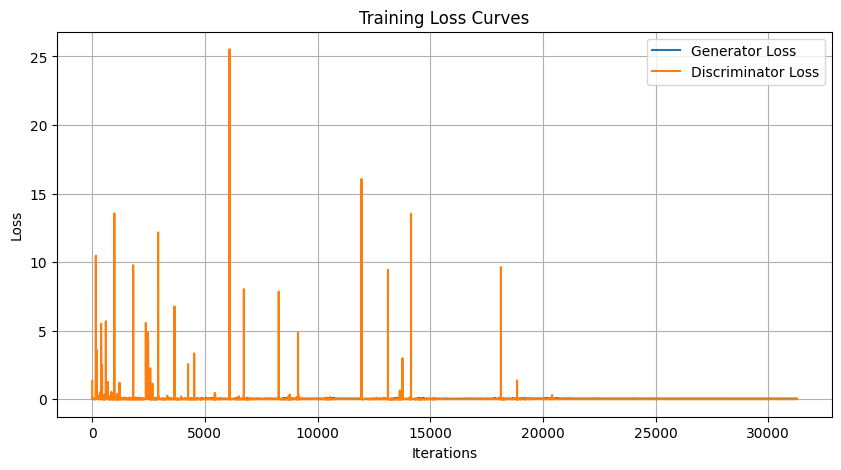

In [10]:
generator = Generator()
discriminator = Discriminator()

train(generator, discriminator, dataloader, num_epochs = 20)

In [11]:
torch.save(generator.state_dict(), "generator.pth")
print("generator saved")

torch.save(discriminator.state_dict(), "discriminator.pth")
print("discriminator saved")

generator saved
discriminator saved


In [13]:
# Loading
generator = Generator().to("cuda")
generator.load_state_dict(torch.load("generator.pth"))
generator.eval()
print("Model Loaded")

Model Loaded


C:\Users\dravi\AppData\Local\Temp\ipykernel_5436\1787141194.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load("generator.pth"))


In [29]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import numpy as np
import torch

In [30]:
## Visualize
def visualize_multiple_batches(generator, dataloader, device="cuda", batches=3, samples_per_batch=4):
    generator.eval()
    with torch.no_grad():
        count = 0
        for lr_imgs, hr_imgs in dataloader:
            lr_imgs = lr_imgs.to(device)
            hr_imgs = hr_imgs.to(device)
            fake_imgs = generator(lr_imgs)
            
            visualize_and_score(lr_imgs, fake_imgs, hr_imgs, n=samples_per_batch)
            count += 1
            if count >= batches:
                break

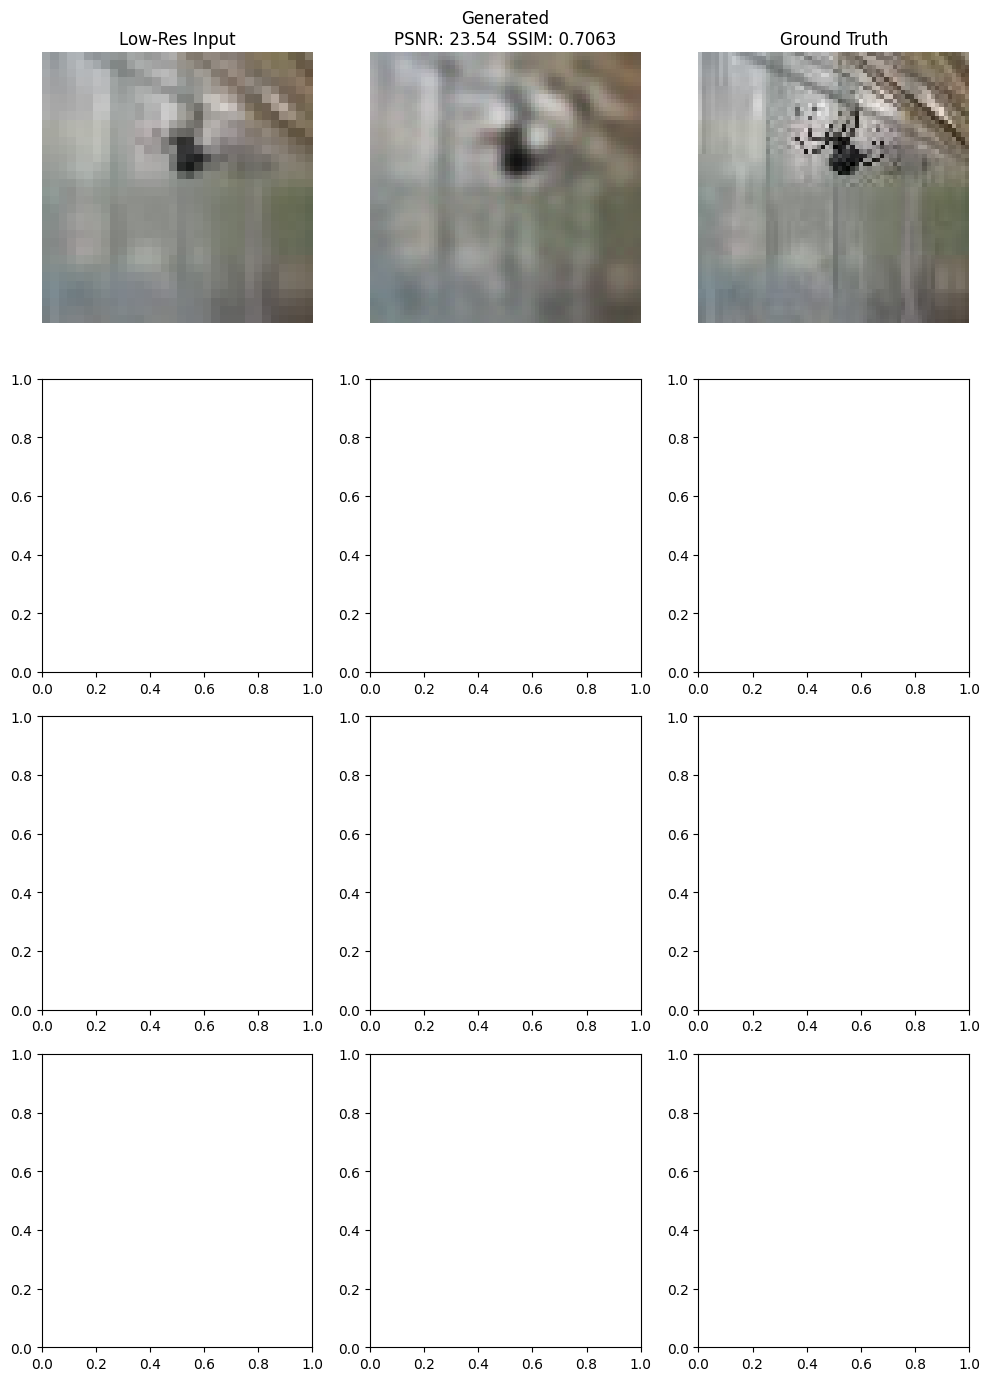

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

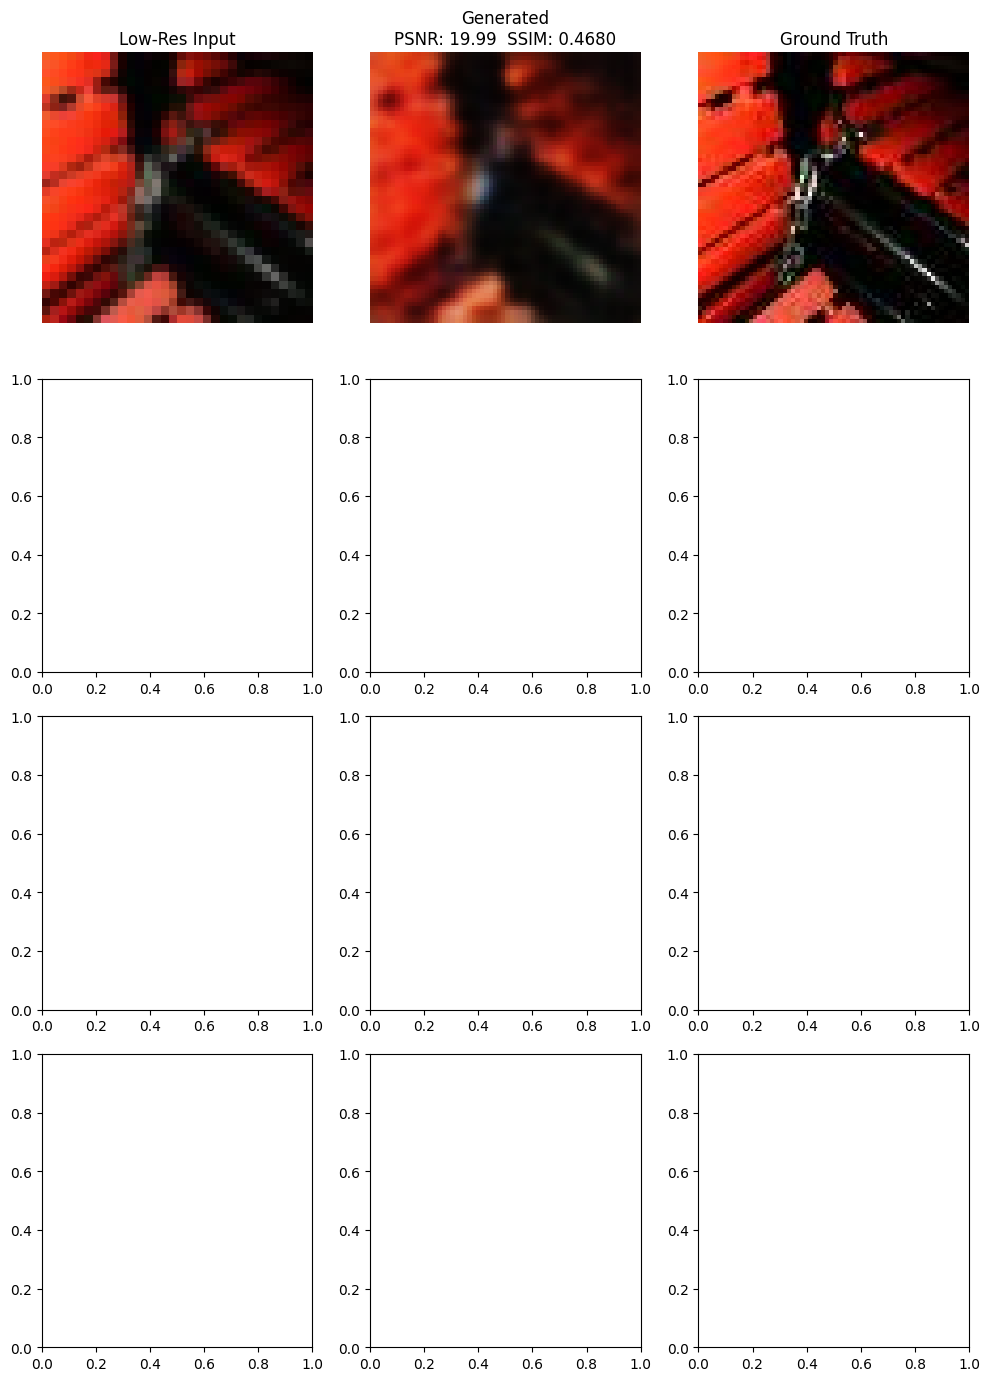

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

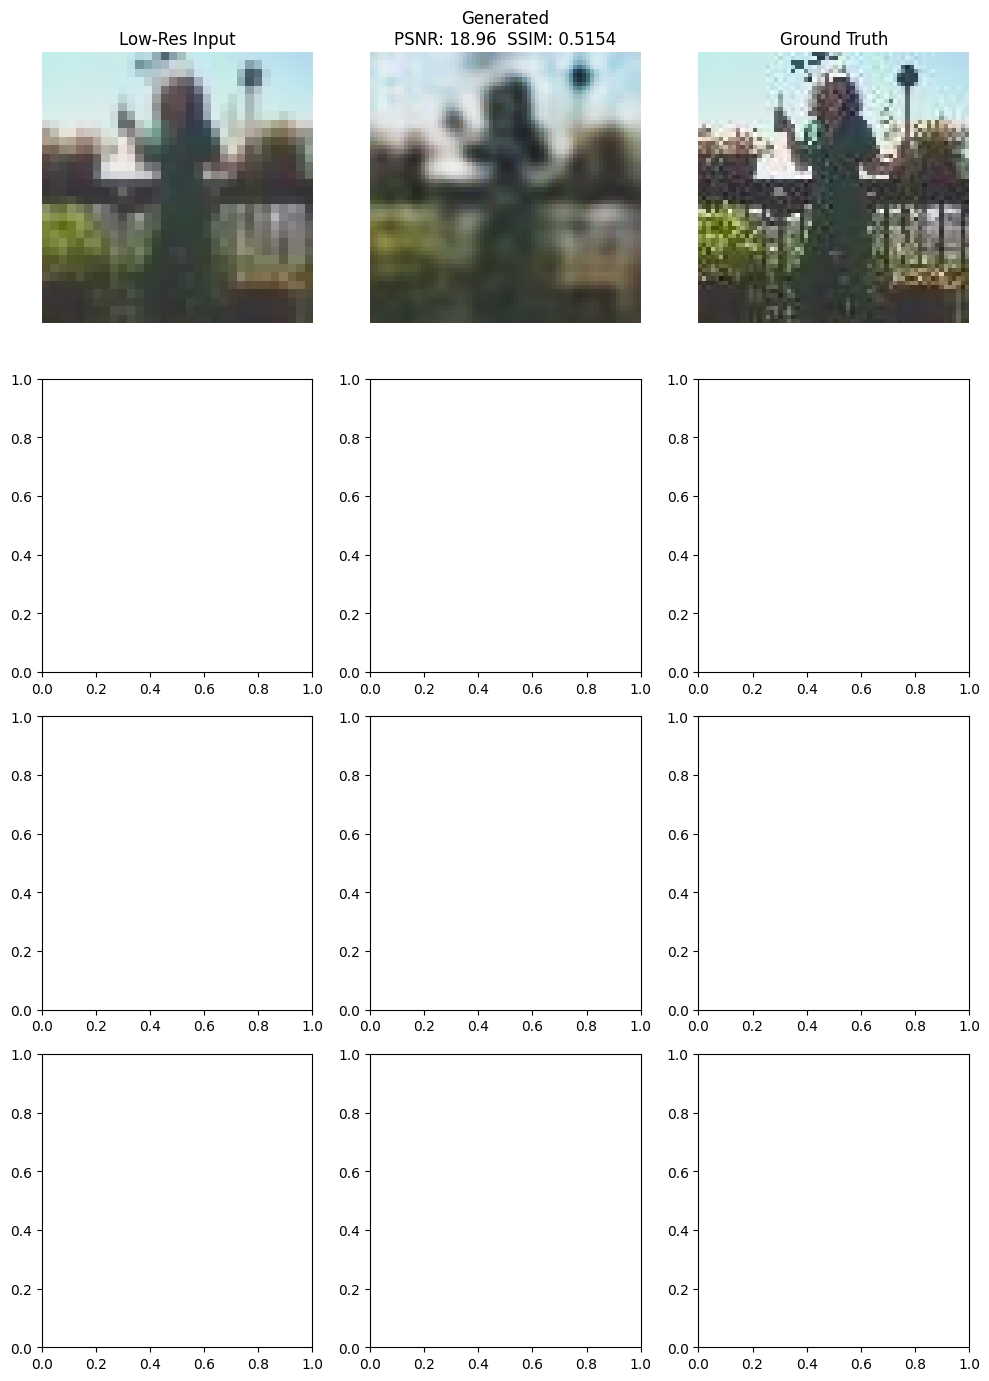

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [31]:
visualize_multiple_batches(generator, dataloader, batches=3, samples_per_batch=4)

In [27]:
# Average PSNR and SSIM
def evaluate_generator(generator, dataloader, device="cuda"):
    generator.eval()
    total_psnr = 0.0
    total_ssim = 0.0
    total_samples = 0

    with torch.no_grad():
        for lr_imgs, hr_imgs in dataloader:
            lr_imgs = lr_imgs.to(device)
            hr_imgs = hr_imgs.to(device)
            fake_imgs = generator(lr_imgs)

            for i in range(len(lr_imgs)):
                psnr, ssim = compute_metrics(fake_imgs[i], hr_imgs[i])
                total_psnr += psnr
                total_ssim += ssim
                total_samples += 1

    avg_psnr = total_psnr / total_samples
    avg_ssim = total_ssim / total_samples
    print(f"Average PSNR: {avg_psnr:.2f}, Average SSIM: {avg_ssim:.4f}")

In [28]:
evaluate_generator(generator, dataloader)

Average PSNR: 20.23, Average SSIM: 0.5836
